## Baseline Model
- for 'sex' and 'race'

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.insert(0, project_root)

import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from src.data_loading import load_adult_sex, load_adult_race
from src.modeling import train_and_predict
from src.metrics import compute_metrics, viz_metrics_2x3, compare_viz_metrics_2x3, save_agg_metrics, save_raw_metrics


/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_di

In [2]:
dataset_name = 'adult'
mitigation_name   = 'baseline'
pipeline_stage    = 'base'   

----------------------------------------

In [3]:
# 1) Retrieve data
protected = 'sex'
privileged_value   = 1.0
unprivileged_value = 0.0

ad, df = load_adult_sex()
feature_cols = [c for c in df.columns if c not in ('label','sex')]

# 2) Run experiment, Evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for train_idx, test_idx in sss.split(df, df['label']):
    test_df, y_test, y_pred = train_and_predict(
        df, feature_cols, train_idx, test_idx
    )
    m = compute_metrics(test_df, y_test, y_pred, protected, privileged_value, unprivileged_value)
    results.append(m)

# 3) Aggregate results
adult_sex_metrics = pd.DataFrame(results)
adult_sex_metrics_agg = adult_sex_metrics.agg(['mean', 'std'])
print(adult_sex_metrics_agg)

      accuracy  f1_score       SPD        DI       EOD       AOD
mean  0.850310  0.654344 -0.174734  0.306197 -0.096939 -0.086041
std   0.002709  0.005680  0.007062  0.020650  0.024995  0.013352


In [4]:
# 1) Retrieve data
protected = 'race'
privileged_value   = 1.0
unprivileged_value = 0.0

ad, df = load_adult_race()
feature_cols = [c for c in df.columns if c not in ('label','race')]

# 2) Run experiment, Evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for train_idx, test_idx in sss.split(df, df['label']):
    test_df, y_test, y_pred = train_and_predict(
        df, feature_cols, train_idx, test_idx
    )
    m = compute_metrics(test_df, y_test, y_pred, protected, privileged_value, unprivileged_value)
    results.append(m)

# 3) Aggregate results
adult_race_metrics = pd.DataFrame(results)
adult_race_metrics_agg = adult_race_metrics.agg(['mean', 'std'])
print(adult_race_metrics_agg)

      accuracy  f1_score       SPD        DI       EOD       AOD
mean  0.850605  0.656032 -0.084891  0.590458 -0.047565 -0.038272
std   0.002979  0.005996  0.005642  0.025659  0.022491  0.010729


-----------------------------------------------------------------------
### plots and save to csv

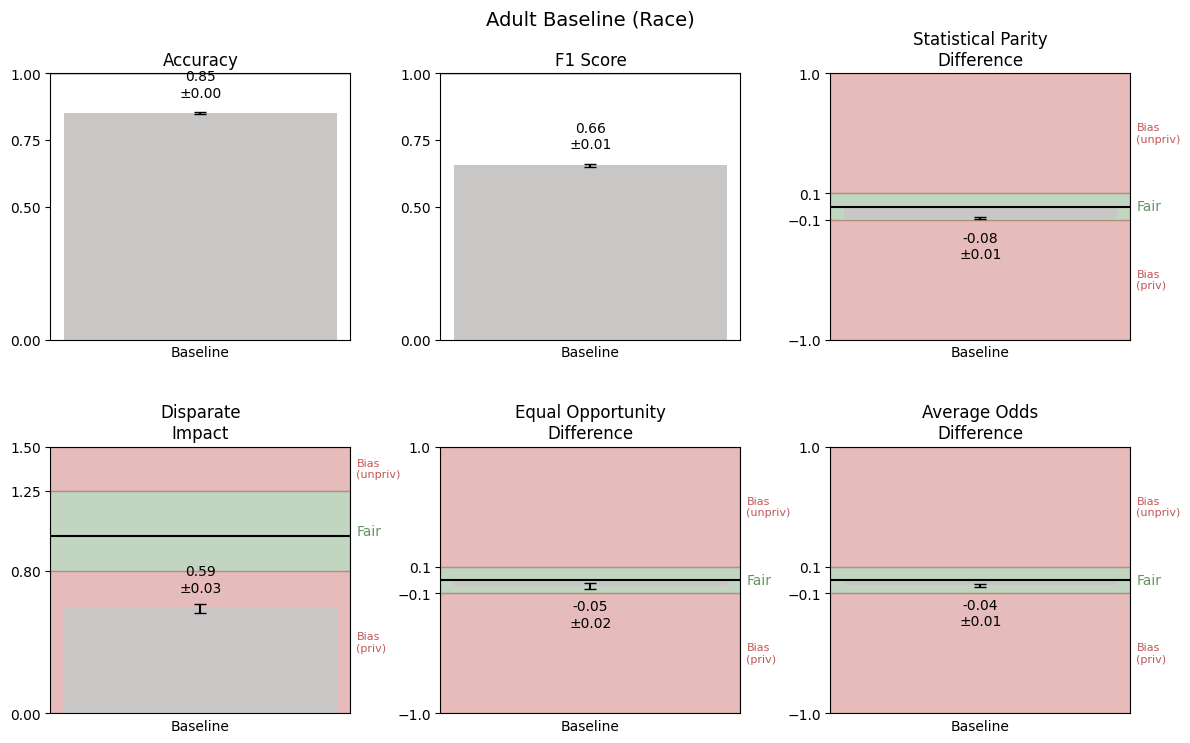

In [5]:
viz_metrics_2x3(adult_race_metrics_agg, title='Adult Baseline (Race)')

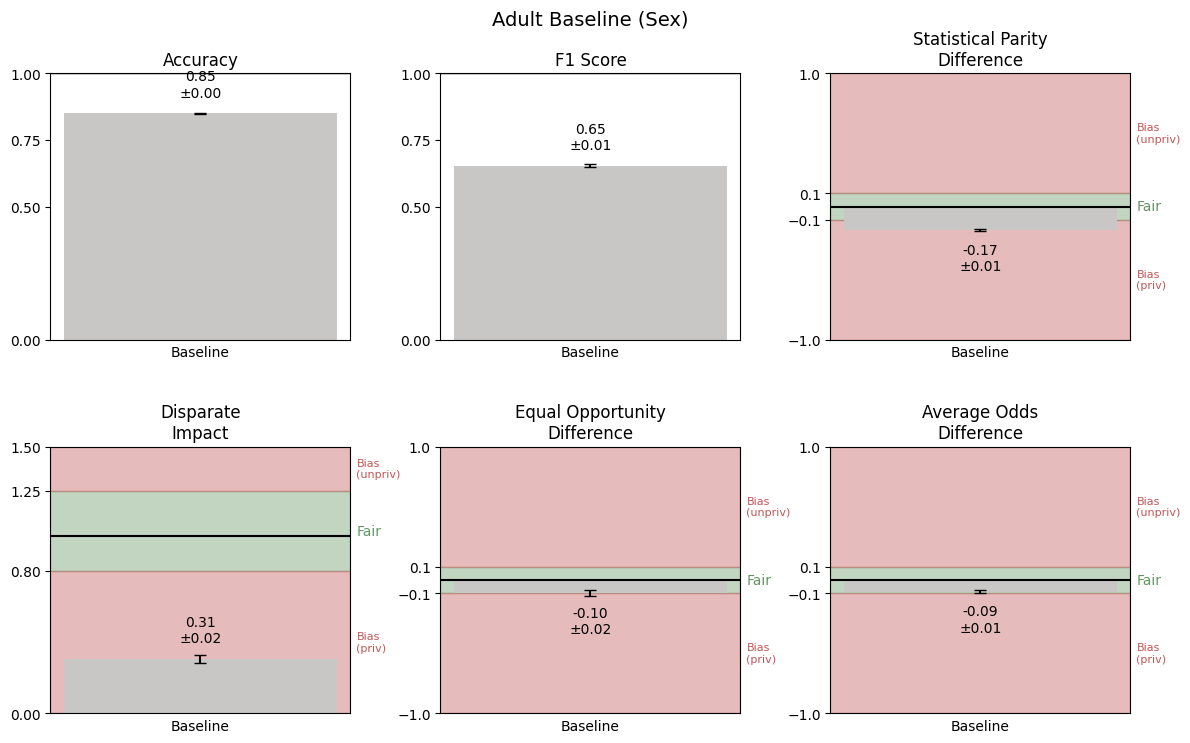

In [6]:
viz_metrics_2x3(adult_sex_metrics_agg, title='Adult Baseline (Sex)')

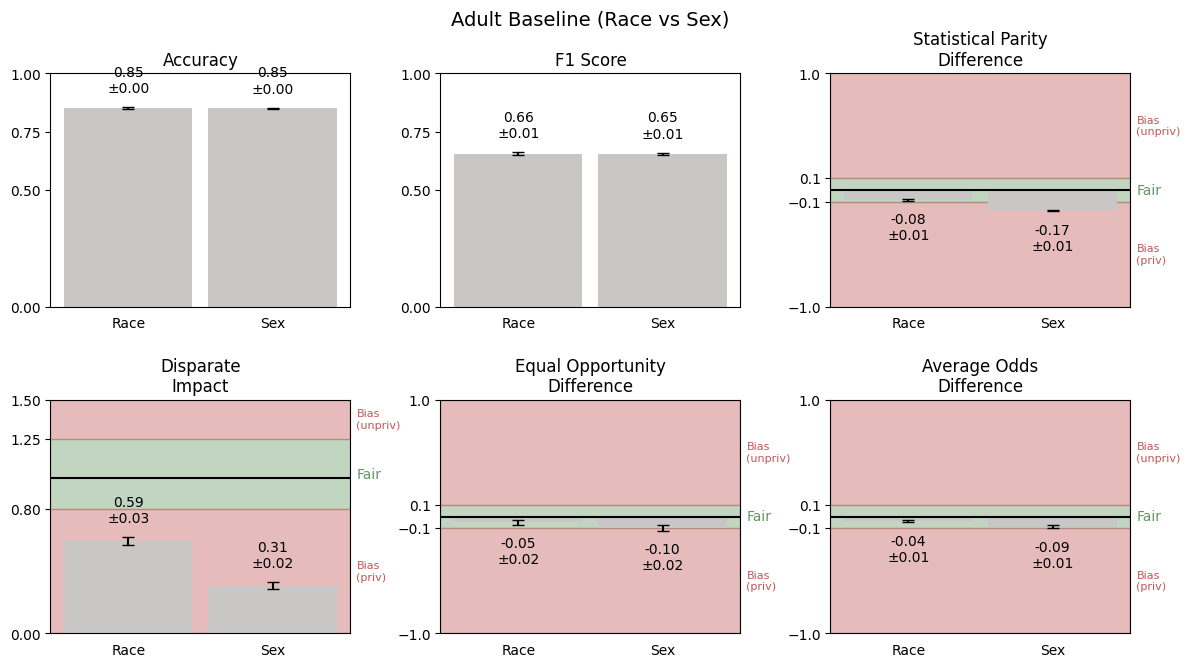

In [7]:
compare_viz_metrics_2x3(adult_race_metrics_agg, adult_sex_metrics_agg, 'Race', 'Sex', 'Adult Baseline (Race vs Sex)')

--------------------------------------


In [8]:
# 1) Save the aggregated metrics 
save_agg_metrics(
    dataset_name = dataset_name,
    mitigation_name   = mitigation_name,
    race_agg_df       = adult_race_metrics_agg,
    sex_agg_df        = adult_sex_metrics_agg,
    pipeline_stage    = pipeline_stage   
)

# 2) Save the raw metrics
save_raw_metrics(
    dataset_name = dataset_name,
    mitigation_name   = mitigation_name,
    race_raw_df       = adult_race_metrics,
    sex_raw_df        = adult_sex_metrics,
    pipeline_stage    = pipeline_stage
)

#### Extract Baseline agg 
-- for easier comparison with the mitigation methods

In [9]:
adult_race_metrics_agg.to_csv('../../reports/baseline_agg/adult_race_metrics_agg.csv', index=True)
adult_sex_metrics_agg.to_csv('../../reports/baseline_agg/adult_sex_metrics_agg.csv', index=True)